In [61]:
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [63]:
solver_df = pd.merge(df[df.solver_version == "data-query-count-10-1000"], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-query-count-10-1000,3.651484,1.0053,21,15,2,0.01,0.168889
1,tools/in/0001.txt,data-query-count-10-1000,9.805807,2.0087,51,13,6,0.04,0.159763
2,tools/in/0002.txt,data-query-count-10-1000,3.922323,1.0167,21,13,2,0.07,0.402367
3,tools/in/0003.txt,data-query-count-10-1000,3.244428,1.0085,21,19,2,0.08,0.315789
4,tools/in/0004.txt,data-query-count-10-1000,47.729708,6.0389,271,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
995,tools/in/0995.txt,data-query-count-10-1000,37.796447,5.0878,201,14,8,0.14,0.346939
996,tools/in/0996.txt,data-query-count-10-1000,18.371173,3.0131,91,12,6,0.09,0.375000
997,tools/in/0997.txt,data-query-count-10-1000,3.922323,1.0476,21,13,4,0.01,0.497041
998,tools/in/0998.txt,data-query-count-10-1000,15.909903,3.0114,91,16,8,0.02,0.289062


In [64]:
solver_df["query_count"] /= (solver_df["n"] ** 2) * 2

In [65]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.666004,0.226556,0.489972,0.322127,-0.158736,0.759873
duration,0.666004,1.000000,0.532941,0.785939,0.422133,-0.178732,0.885884
n,0.226556,0.532941,1.000000,0.570359,0.000661,-0.005304,0.157576
m,0.489972,0.785939,0.570359,1.000000,-0.048762,-0.059006,0.592925
eps,0.322127,0.422133,0.000661,-0.048762,1.000000,-0.016663,0.518376
dense,-0.158736,-0.178732,-0.005304,-0.059006,-0.016663,1.000000,-0.223040
query_count,0.759873,0.885884,0.157576,0.592925,0.518376,-0.223040,1.000000


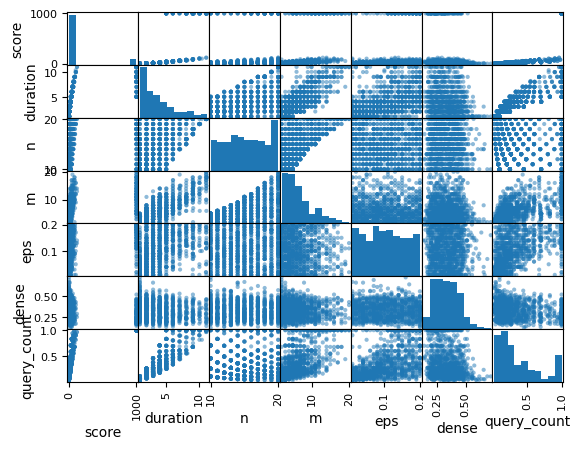

In [66]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

<AxesSubplot:>

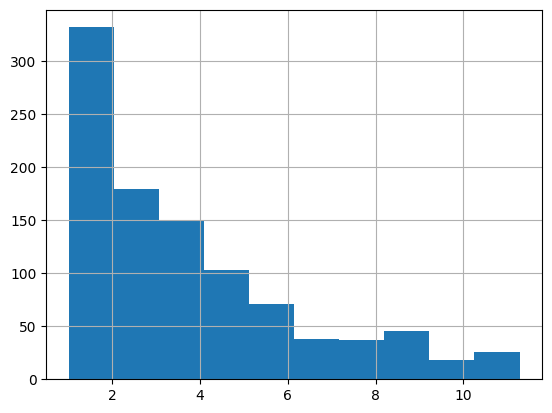

In [67]:
solver_df.duration.hist()

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == "data-query-count-10-1000"], input_df, how="left", on="input_file")

In [69]:
data_df = solver_df[num_cols]
data_df["query_count"] /= (data_df["n"] ** 2) * 2
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(["score", "duration", "query_count"], axis=1)

feature_cols = ["n", "m", "eps", "dense"]

alphas = [0.5, 0.8, 1.5, 2.0]

# 特徴量
for col in feature_cols:
    for alpha in alphas:
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

for col1 in feature_cols:
    for alpha1 in alphas:
        for col2 in feature_cols:
            for alpha2 in alphas:
                c1 = f"{col1}.powf({alpha1})"
                c2 = f"{col2}.powf({alpha2})"
                data_df.loc[:, [f"{c1} * {c2}"]] = data_df[c1] * data_df[c2]
                data_df.loc[:, [f"{c1} / {c2}"]] = data_df[c1] / data_df[c2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e2)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)]) + f" + {model.intercept_:.5}"
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

/var/folders/3n/z49mbd414cx0_x991z2fyqjc0000gn/T/ipykernel_68572/1973810361.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["query_count"] /= (data_df["n"] ** 2) * 2


0.8308438918285693
0.8110354647174345
-0.0003135 * n + 0.0015993 * m + 0.00046855 * eps + -8.5661e-05 * dense + -7.4839e-05 * n.powf(0.5) + -0.00018926 * n.powf(0.8) + -0.00084708 * n.powf(1.5) + -0.0015434 * n.powf(2.0) + 0.00056574 * m.powf(0.5) + 0.0011305 * m.powf(0.8) + 0.0028642 * m.powf(1.5) + 0.0031457 * m.powf(2.0) + 0.00053137 * eps.powf(0.5) + 0.00052536 * eps.powf(0.8) + 0.00028953 * eps.powf(1.5) + 0.00015222 * eps.powf(2.0) + -6.1316e-05 * dense.powf(0.5) + -7.8188e-05 * dense.powf(0.8) + -9.946e-05 * dense.powf(1.5) + -0.00011232 * dense.powf(2.0) + -0.0003135 * n.powf(0.5) * n.powf(0.5) + 0.0 * n.powf(0.5) / n.powf(0.5) + -0.00059395 * n.powf(0.5) * n.powf(0.8) + 1.141e-05 * n.powf(0.5) / n.powf(0.8) + -0.0015434 * n.powf(0.5) * n.powf(1.5) + 1.0175e-05 * n.powf(0.5) / n.powf(1.5) + -0.0012258 * n.powf(0.5) * n.powf(2.0) + 5.682e-06 * n.powf(0.5) / n.powf(2.0) + 0.0010051 * n.powf(0.5) * m.powf(0.5) + -0.00051815 * n.powf(0.5) / m.powf(0.5) + 0.0019916 * n.powf(0.5) * m

1.0 1.0401511017544753
1.0 0.48782468667666185
0.07291666666666667 0.08352242884174421
0.2692307692307692 0.20805361605291073
0.67625 0.633361683584897
0.98 0.8799848986483413
0.3159722222222222 0.24931653173051083
0.5946745562130178 0.5077389110597963
0.610803324099723 0.6924590060162978
0.08823529411764706 0.09888455623345027


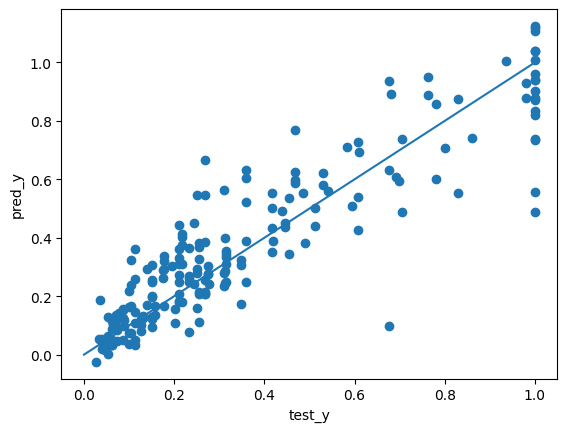

In [70]:
pred_y = model.predict(test_x)
for i in range(10):
    print(test_y.iloc[i], pred_y[i])

plt.scatter(test_y, pred_y)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([0, 1], [0, 1])

In [71]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=10)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

0.7095270871968953


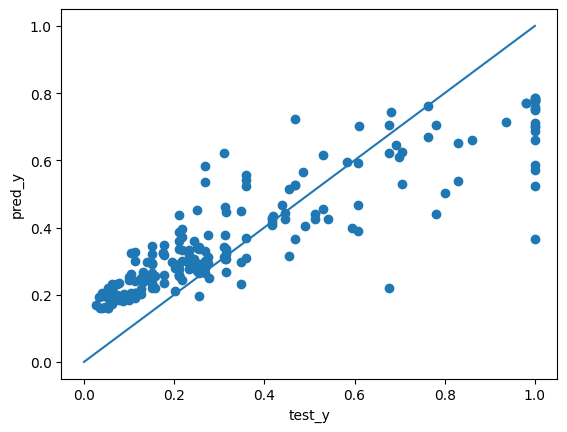

In [72]:
plt.scatter(test_y, pred_y)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([0, 1], [0, 1])